In [29]:
# pip install vaderSentiment
# !pip install -U textblob
# !pip install --user flair
!pip install WordCloud

     |████████████████████████████████| 225kB 951kB/s eta 0:00:01
  Created wheel for WordCloud: filename=wordcloud-1.8.1-cp37-cp37m-macosx_10_9_x86_64.whl size=158978 sha256=eeb526c3b8e69b069d2e51a243239248665b013b852af301d5bb6cf71d3ab539
  Stored in directory: /Users/anishajauhari/Library/Caches/pip/wheels/bf/18/33/c6d0e1bb532e0587da731a02d990e62c483c8e49741e0c4bf3
Successfully built WordCloud


## Loading Libraries

In [1]:
import pandas as pd
import numpy as np
import datetime
from textblob import TextBlob, Word, Blobber
import glob
import flair
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Match Data

In [2]:
match_data = pd.read_excel("../data/ManUtd Matches.xlsx")

In [3]:
match_data

,Opponent,Date,Outcome,Score
0,Leeds United,2021-08-14,Won,5-1
1,Southampton,2021-08-22,Draw,1-1
2,Wolves,2021-08-29,Won,1-0
3,Newcastle United,2021-09-11,Won,4-1
4,Young Boys,2021-09-14,Won,1-0
5,West Ham,2021-09-19,Won,2-1
6,West Ham,2021-09-22,Lost,0-1
7,Aston Villa,2021-09-25,Lost,0-1
8,Villareal,2021-09-29,Won,2-1
9,Everton,2021-10-02,Draw,1-1


## Analysing Sentiments of Official Twitter Accounts

In [4]:
def getMatchSentiments(file):
    dataset = pd.read_csv(file)
    dataset = dataset.drop(columns = ["Unnamed: 0"])
    analyzer = SentimentIntensityAnalyzer()
    dataset["sentiment_compound_score"] = dataset["Text"].apply(lambda x : analyzer.polarity_scores(str(x)))
    df = pd.json_normalize(dataset['sentiment_compound_score'])
    dataset_updated = pd.merge(dataset, df, how="inner", right_index = True, left_index= True)
    dataset_updated["sentiment"] = dataset_updated["compound"].apply(lambda x : "Positive" if (x > 0.05) else ("Neutral" if (x > -0.05 and x < 0.05) else "Negative"))
    display(dataset_updated.head(2))
    value_counts = dataset_updated["sentiment"].value_counts().to_frame().T
    return value_counts

In [5]:
def getMatchSentimentsUsingTextBlob(file):
    dataset = pd.read_csv(file)
    dataset = dataset.drop(columns = ["Unnamed: 0"])
    dataset["sentiment_score"] = dataset["Text"].apply(lambda x : TextBlob(str(x)).sentiment.polarity)
    dataset["sentiment"] = dataset["sentiment_score"].apply(lambda x : "Positive" if (x>0) else ("Neutral" if (x==0) else "Negative"))
    display(dataset)
    value_counts = dataset["sentiment"].value_counts().to_frame().T
    return value_counts

In [6]:
def getMatchSentimentsUsingFlair(file):
    dataset = pd.read_csv(file)
    dataset = dataset.drop(columns = ["Unnamed: 0"])
    flair_sentiment = flair.models.TextClassifier.load('en-sentiment')
    sentiments = []
    labels = []
    for i, row in dataset.iterrows():
        sentence = flair.data.Sentence(str(row["Text"]))
        flair_sentiment.predict(sentence)
        value = sentence.labels[0].to_dict()['value'] 
        if value == 'POSITIVE':
            labels.append(value)
            result = sentence.to_dict()['labels'][0]['confidence']
            sentiments.append(result)
        else:
            labels.append(value)
            result = -(sentence.to_dict()['labels'][0]['confidence'])
            sentiments.append(result)
#         dataset["sentiment_score"] = 
    dataset["sentiment_score"] = sentiments
    dataset["sentiment"] = labels
    print(dataset)
#     dataset["sentiment"] = dataset["sentiment_score"].apply(lambda x : "Positive" if (x>0) else ("Neutral" if (x==0) else "Negative"))
#     display(dataset)
    value_counts = dataset["sentiment"].value_counts().to_frame().T
    return value_counts

In [15]:
files = []
for file in glob.glob("../data/Official Tweets/*"):
    file=file.replace("\\","/")
    files.append(file)

In [16]:
match_sentiments = pd.DataFrame(columns = ["Date", "Outcome", "Positive", "Negative"])
for file in files:
    match_date = datetime.datetime.strptime(file.split("/")[3].split(".")[0]+" 2021", '%d-%b %Y')
    print("Reading Match Sentiments for - ", match_date)
    value_counts = getMatchSentimentsUsingFlair(file)
    match_data["Date"] = match_data["Date"].apply(lambda x : str(x))
    outcome = match_data[match_data["Date"] == str(match_date)]["Outcome"].values[0]
    display(value_counts)
    display(outcome)
    df = pd.DataFrame([[match_date, outcome, value_counts["POSITIVE"]["sentiment"], value_counts["NEGATIVE"]["sentiment"]]], columns = ["Date", "Outcome", "Positive", "Negative"])
    match_sentiments = match_sentiments.append(df)



Reading Match Sentiments for -  2021-10-24 00:00:00
2021-12-10 11:47:07,112 loading file /Users/anishajauhari/.flair/models/sentiment-en-mix-distillbert_4.pt
                     Datetime             Tweet Id  \
0   2021-10-24 21:46:00+00:00  1452390945656168448   
1   2021-10-24 20:31:00+00:00  1452372071346958336   
2   2021-10-24 19:23:15+00:00  1452355022134681601   
3   2021-10-24 17:24:04+00:00  1452325028712919040   
4   2021-10-24 16:53:53+00:00  1452317433923084295   
5   2021-10-24 16:50:34+00:00  1452316599390777352   
6   2021-10-24 16:40:08+00:00  1452313972233969700   
7   2021-10-24 16:36:43+00:00  1452313111814447119   
8   2021-10-24 16:35:39+00:00  1452312845446696962   
9   2021-10-24 16:21:41+00:00  1452309328581517318   
10  2021-10-24 16:20:15+00:00  1452308967162621959   
11  2021-10-24 16:08:25+00:00  1452305993040338960   
12  2021-10-24 15:56:42+00:00  1452303042687209472   
13  2021-10-24 15:44:17+00:00  1452299917016375307   
14  2021-10-24 15:35:37+00:00  1

,POSITIVE,NEGATIVE
sentiment,38,11


'Lost'

Reading Match Sentiments for -  2021-10-02 00:00:00
2021-12-10 11:47:25,912 loading file /Users/anishajauhari/.flair/models/sentiment-en-mix-distillbert_4.pt
                     Datetime             Tweet Id  \
0   2021-10-02 22:28:00+00:00  1444428982238134273   
1   2021-10-02 21:02:00+00:00  1444407339986083844   
2   2021-10-02 19:27:00+00:00  1444383432147148803   
3   2021-10-02 18:36:00+00:00  1444370597643882497   
4   2021-10-02 17:44:00+00:00  1444357511461494790   
5   2021-10-02 16:33:00+00:00  1444339643810557953   
6   2021-10-02 15:27:00+00:00  1444323034186330123   
7   2021-10-02 14:46:00+00:00  1444312716261281794   
8   2021-10-02 13:23:58+00:00  1444292071360245760   
9   2021-10-02 13:11:12+00:00  1444288858540085257   
10  2021-10-02 13:05:01+00:00  1444287305527795716   
11  2021-10-02 12:59:06+00:00  1444285813597081604   
12  2021-10-02 12:53:40+00:00  1444284446094643200   
13  2021-10-02 12:46:53+00:00  1444282742288658432   
14  2021-10-02 12:34:23+00:00  1

,POSITIVE,NEGATIVE
sentiment,35,11


'Draw'

Reading Match Sentiments for -  2021-09-25 00:00:00
2021-12-10 11:47:42,267 loading file /Users/anishajauhari/.flair/models/sentiment-en-mix-distillbert_4.pt
                     Datetime             Tweet Id  \
0   2021-09-25 19:42:04+00:00  1441850509565087751   
1   2021-09-25 17:36:00+00:00  1441818782981181441   
2   2021-09-25 15:18:49+00:00  1441784259191181316   
3   2021-09-25 14:12:46+00:00  1441767639743819784   
4   2021-09-25 13:50:32+00:00  1441762041744826369   
5   2021-09-25 13:25:38+00:00  1441755779342688256   
6   2021-09-25 13:17:38+00:00  1441753763455197185   
7   2021-09-25 13:14:30+00:00  1441752976008237058   
8   2021-09-25 13:11:47+00:00  1441752292949123073   
9   2021-09-25 13:00:51+00:00  1441749541888294920   
10  2021-09-25 12:55:58+00:00  1441748309899681795   
11  2021-09-25 12:54:02+00:00  1441747823515471881   
12  2021-09-25 12:34:50+00:00  1441742993044619272   
13  2021-09-25 12:28:09+00:00  1441741312575868930   
14  2021-09-25 12:19:44+00:00  1

,POSITIVE,NEGATIVE
sentiment,33,12


'Lost'

Reading Match Sentiments for -  2021-11-02 00:00:00
2021-12-10 11:47:59,666 loading file /Users/anishajauhari/.flair/models/sentiment-en-mix-distillbert_4.pt
                     Datetime             Tweet Id  \
0   2021-11-02 23:31:59+00:00  1455679110974517256   
1   2021-11-02 23:06:00+00:00  1455672569152016389   
2   2021-11-02 22:50:04+00:00  1455668562488606720   
3   2021-11-02 22:44:12+00:00  1455667083723825152   
4   2021-11-02 22:26:57+00:00  1455662742346600453   
5   2021-11-02 22:16:14+00:00  1455660047078469648   
6   2021-11-02 22:07:26+00:00  1455657832792182786   
7   2021-11-02 21:56:56+00:00  1455655187008430085   
8   2021-11-02 21:52:26+00:00  1455654057033543690   
9   2021-11-02 21:48:28+00:00  1455653058235576323   
10  2021-11-02 21:37:41+00:00  1455650343350644736   
11  2021-11-02 21:30:20+00:00  1455648493020794882   
12  2021-11-02 21:18:09+00:00  1455645428448468993   
13  2021-11-02 21:05:42+00:00  1455642295152398340   
14  2021-11-02 21:03:04+00:00  1

,POSITIVE,NEGATIVE
sentiment,52,8


'Draw'

Reading Match Sentiments for -  2021-09-11 00:00:00
2021-12-10 11:48:18,994 loading file /Users/anishajauhari/.flair/models/sentiment-en-mix-distillbert_4.pt
                     Datetime             Tweet Id  \
0   2021-09-11 23:08:46+00:00  1436829099343949826   
1   2021-09-11 21:37:00+00:00  1436806002486046722   
2   2021-09-11 21:00:59+00:00  1436796939757146119   
3   2021-09-11 20:34:00+00:00  1436790148075704320   
4   2021-09-11 19:55:00+00:00  1436780333471608838   
..                        ...                  ...   
83  2021-09-11 16:31:17+00:00  1436729066808295434   
84  2021-09-11 16:31:10+00:00  1436729038693969928   
85  2021-09-11 21:00:12+00:00  1436796741630709767   
86  2021-09-11 18:51:43+00:00  1436764409003659267   
87  2021-09-11 18:24:50+00:00  1436757644170219525   

                                                 Text         Username  \
0   Congratulations on becoming the #USOpen champi...           ManUtd   
1   ☝️ @Cristiano ☝️\n\nSweet dreams, Reds 🥰 

,POSITIVE,NEGATIVE
sentiment,68,20


'Won'

Reading Match Sentiments for -  2021-09-19 00:00:00
2021-12-10 11:48:39,052 loading file /Users/anishajauhari/.flair/models/sentiment-en-mix-distillbert_4.pt
                     Datetime             Tweet Id  \
0   2021-09-19 21:30:00+00:00  1439703345069916162   
1   2021-09-19 21:00:00+00:00  1439695794873982976   
2   2021-09-19 19:51:00+00:00  1439678429742485505   
3   2021-09-19 18:23:00+00:00  1439656283905351681   
4   2021-09-19 17:47:00+00:00  1439647224070348801   
5   2021-09-19 17:15:00+00:00  1439639170956226561   
6   2021-09-19 16:58:00+00:00  1439634892804001792   
7   2021-09-19 16:51:28+00:00  1439633249639313411   
8   2021-09-19 16:32:48+00:00  1439628551632850960   
9   2021-09-19 15:56:22+00:00  1439619382573928457   
10  2021-09-19 15:45:55+00:00  1439616755127754754   
11  2021-09-19 15:19:33+00:00  1439610119222927372   
12  2021-09-19 15:15:15+00:00  1439609034441740289   
13  2021-09-19 15:08:03+00:00  1439607224817655821   
14  2021-09-19 15:05:59+00:00  1

,POSITIVE,NEGATIVE
sentiment,47,11


'Won'

Reading Match Sentiments for -  2021-11-06 00:00:00
2021-12-10 11:48:56,820 loading file /Users/anishajauhari/.flair/models/sentiment-en-mix-distillbert_4.pt
                     Datetime             Tweet Id  \
0   2021-11-06 17:13:00+00:00  1457033285322919937   
1   2021-11-06 15:41:00+00:00  1457010132928270346   
2   2021-11-06 14:24:21+00:00  1456990845270470663   
3   2021-11-06 14:10:28+00:00  1456987351037644803   
4   2021-11-06 14:04:01+00:00  1456985725837189127   
5   2021-11-06 13:57:34+00:00  1456984102192746505   
6   2021-11-06 13:53:19+00:00  1456983034121576450   
7   2021-11-06 13:36:28+00:00  1456978793516568580   
8   2021-11-06 13:34:49+00:00  1456978377739472898   
9   2021-11-06 13:20:11+00:00  1456974697497874434   
10  2021-11-06 13:18:01+00:00  1456974149394571274   
11  2021-11-06 13:03:07+00:00  1456970402165665798   
12  2021-11-06 12:58:26+00:00  1456969222127603721   
13  2021-11-06 12:40:12+00:00  1456964633986846720   
14  2021-11-06 12:32:18+00:00  1

,POSITIVE,NEGATIVE
sentiment,30,8


'Lost'

Reading Match Sentiments for -  2021-08-22 00:00:00
2021-12-10 11:49:14,910 loading file /Users/anishajauhari/.flair/models/sentiment-en-mix-distillbert_4.pt
                     Datetime             Tweet Id  \
0   2021-08-22 21:02:00+00:00  1429549437467172877   
1   2021-08-22 17:05:00+00:00  1429489794409771016   
2   2021-08-22 16:01:22+00:00  1429473780745768960   
3   2021-08-22 15:47:00+00:00  1429470164924436482   
4   2021-08-22 15:34:50+00:00  1429467103594176518   
5   2021-08-22 15:18:33+00:00  1429463005981466627   
6   2021-08-22 15:11:40+00:00  1429461273759059977   
7   2021-08-22 14:53:31+00:00  1429456704710840327   
8   2021-08-22 14:43:36+00:00  1429454212543488014   
9   2021-08-22 14:34:14+00:00  1429451853171994624   
10  2021-08-22 14:31:40+00:00  1429451205831532549   
11  2021-08-22 14:24:42+00:00  1429449454701195266   
12  2021-08-22 14:18:27+00:00  1429447881203884040   
13  2021-08-22 14:16:32+00:00  1429447397265055750   
14  2021-08-22 14:12:00+00:00  1

,POSITIVE,NEGATIVE
sentiment,37,9


'Draw'

Reading Match Sentiments for -  2021-11-20 00:00:00
2021-12-10 11:49:31,957 loading file /Users/anishajauhari/.flair/models/sentiment-en-mix-distillbert_4.pt
                     Datetime             Tweet Id  \
0   2021-11-20 19:08:30+00:00  1462135781800263680   
1   2021-11-20 16:55:04+00:00  1462102202588270605   
2   2021-11-20 16:54:03+00:00  1462101948572872710   
3   2021-11-20 16:50:24+00:00  1462101030053810186   
4   2021-11-20 16:44:24+00:00  1462099519076802565   
5   2021-11-20 16:39:22+00:00  1462098250442416132   
6   2021-11-20 16:28:28+00:00  1462095509770969100   
7   2021-11-20 16:19:38+00:00  1462093287251185669   
8   2021-11-20 16:12:40+00:00  1462091533096783876   
9   2021-11-20 16:09:37+00:00  1462090764566028305   
10  2021-11-20 16:05:23+00:00  1462089700232073217   
11  2021-11-20 16:03:38+00:00  1462089261751181318   
12  2021-11-20 15:48:27+00:00  1462085439393832963   
13  2021-11-20 15:43:59+00:00  1462084315332886541   
14  2021-11-20 15:34:32+00:00  1

,POSITIVE,NEGATIVE
sentiment,31,10


'Lost'

Reading Match Sentiments for -  2021-08-14 00:00:00
2021-12-10 11:49:48,365 loading file /Users/anishajauhari/.flair/models/sentiment-en-mix-distillbert_4.pt
                     Datetime             Tweet Id  \
0   2021-08-14 23:04:00+00:00  1426681036818325506   
1   2021-08-14 22:26:00+00:00  1426671473633071104   
2   2021-08-14 21:39:00+00:00  1426659645519798272   
3   2021-08-14 21:02:05+00:00  1426650355002187778   
4   2021-08-14 20:49:00+00:00  1426647062691688450   
..                        ...                  ...   
86  2021-08-14 14:15:26+00:00  1426548018946486277   
87  2021-08-14 18:57:47+00:00  1426619074017177606   
88  2021-08-14 15:19:03+00:00  1426564029569454081   
89  2021-08-14 13:58:05+00:00  1426543651564527621   
90  2021-08-14 15:13:32+00:00  1426562641363865602   

                                                 Text         Username  \
0   Seeing a full Old Trafford made Saturday's res...           ManUtd   
1   For those we lost during the pandemic ❤️\

,POSITIVE,NEGATIVE
sentiment,76,15


'Won'

Reading Match Sentiments for -  2021-09-14 00:00:00
2021-12-10 11:50:10,767 loading file /Users/anishajauhari/.flair/models/sentiment-en-mix-distillbert_4.pt
                     Datetime             Tweet Id  \
0   2021-09-14 20:55:00+00:00  1437882596495695880   
1   2021-09-14 20:01:41+00:00  1437869180158676998   
2   2021-09-14 19:18:51+00:00  1437858400239595536   
3   2021-09-14 18:39:35+00:00  1437848520275501058   
4   2021-09-14 18:37:57+00:00  1437848106352132100   
5   2021-09-14 18:33:30+00:00  1437846989673218049   
6   2021-09-14 18:24:12+00:00  1437844645808115712   
7   2021-09-14 18:17:01+00:00  1437842841422737412   
8   2021-09-14 18:09:10+00:00  1437840864945090561   
9   2021-09-14 18:01:33+00:00  1437838945916788745   
10  2021-09-14 17:49:57+00:00  1437836030137229320   
11  2021-09-14 17:48:18+00:00  1437835613517013001   
12  2021-09-14 17:32:11+00:00  1437831556098412545   
13  2021-09-14 17:24:30+00:00  1437829624915009543   
14  2021-09-14 17:20:41+00:00  1

,POSITIVE,NEGATIVE
sentiment,34,10


'Won '

Reading Match Sentiments for -  2021-09-22 00:00:00
2021-12-10 11:50:27,590 loading file /Users/anishajauhari/.flair/models/sentiment-en-mix-distillbert_4.pt
                     Datetime             Tweet Id  \
0   2021-09-22 23:24:56+00:00  1440819433161703425   
1   2021-09-22 21:38:46+00:00  1440792712739840002   
2   2021-09-22 21:01:50+00:00  1440783418988449792   
3   2021-09-22 20:54:23+00:00  1440781543442583555   
4   2021-09-22 20:38:53+00:00  1440777645571010560   
5   2021-09-22 20:18:11+00:00  1440772435939237891   
6   2021-09-22 20:14:58+00:00  1440771626618933251   
7   2021-09-22 20:08:07+00:00  1440769903636615179   
8   2021-09-22 20:02:37+00:00  1440768516257304583   
9   2021-09-22 19:49:45+00:00  1440765278527184908   
10  2021-09-22 19:32:53+00:00  1440761036483674116   
11  2021-09-22 19:14:19+00:00  1440756361600520197   
12  2021-09-22 19:10:26+00:00  1440755387053969411   
13  2021-09-22 18:58:54+00:00  1440752482225831940   
14  2021-09-22 18:54:37+00:00  1

,POSITIVE,NEGATIVE
sentiment,29,10


'Lost'

Reading Match Sentiments for -  2021-11-28 00:00:00
2021-12-10 11:50:44,630 loading file /Users/anishajauhari/.flair/models/sentiment-en-mix-distillbert_4.pt
                     Datetime             Tweet Id  \
0   2021-11-28 22:48:00+00:00  1465090123956035586   
1   2021-11-28 22:00:01+00:00  1465078047665647620   
2   2021-11-28 21:31:00+00:00  1465070746238009347   
3   2021-11-28 21:00:00+00:00  1465062946422366216   
4   2021-11-28 20:29:00+00:00  1465055143473283078   
5   2021-11-28 19:58:00+00:00  1465047341895872518   
6   2021-11-28 19:34:00+00:00  1465041302286962700   
7   2021-11-28 19:06:44+00:00  1465034439466135555   
8   2021-11-28 18:44:48+00:00  1465028923713069065   
9   2021-11-28 18:23:28+00:00  1465023551245848577   
10  2021-11-28 18:15:03+00:00  1465021436884668422   
11  2021-11-28 18:03:53+00:00  1465018625702739977   
12  2021-11-28 18:01:51+00:00  1465018112315637776   
13  2021-11-28 17:54:53+00:00  1465016358685585409   
14  2021-11-28 17:50:50+00:00  1

,POSITIVE,NEGATIVE
sentiment,47,5


'Draw'

Reading Match Sentiments for -  2021-10-20 00:00:00
2021-12-10 11:51:03,764 loading file /Users/anishajauhari/.flair/models/sentiment-en-mix-distillbert_4.pt
                     Datetime             Tweet Id  \
0   2021-10-20 23:32:00+00:00  1450968070193762311   
1   2021-10-20 23:14:00+00:00  1450963540169265160   
2   2021-10-20 22:59:00+00:00  1450959765228572673   
3   2021-10-20 22:48:16+00:00  1450957066777120769   
4   2021-10-20 22:39:43+00:00  1450954913438224388   
..                        ...                  ...   
64  2021-10-20 21:49:52+00:00  1450942369768124417   
65  2021-10-20 17:59:25+00:00  1450884372488404993   
66  2021-10-20 22:39:14+00:00  1450954792461811714   
67  2021-10-20 21:59:22+00:00  1450944757664997379   
68  2021-10-20 21:31:00+00:00  1450937620993822723   

                                                 Text         Username  \
0                           😍 https://t.co/rL94SlgEIT           ManUtd   
1   Oh what a night, oh what a night 🥰\n\n#MU

,POSITIVE,NEGATIVE
sentiment,64,5


'Won'

Reading Match Sentiments for -  2021-10-30 00:00:00
2021-12-10 11:51:22,868 loading file /Users/anishajauhari/.flair/models/sentiment-en-mix-distillbert_4.pt
                     Datetime             Tweet Id  \
0   2021-10-30 22:48:00+00:00  1454580875673288705   
1   2021-10-30 22:35:00+00:00  1454577604262957058   
2   2021-10-30 21:45:00+00:00  1454565021233475584   
3   2021-10-30 21:31:00+00:00  1454561498110459905   
4   2021-10-30 21:01:00+00:00  1454553948472233987   
..                        ...                  ...   
72  2021-10-30 18:46:55+00:00  1454520204709568515   
73  2021-10-30 22:06:52+00:00  1454570524760227849   
74  2021-10-30 15:36:32+00:00  1454472295758635010   
75  2021-10-30 19:40:10+00:00  1454533605250764804   
76  2021-10-30 18:54:32+00:00  1454522123700088834   

                                                 Text         Username  \
0   Our away fans in fine voice as always 👏👏👏\n\n#...           ManUtd   
1   Together ✊\n\nThank you for your magnific

,POSITIVE,NEGATIVE
sentiment,62,15


'Won'

Reading Match Sentiments for -  2021-09-29 00:00:00
2021-12-10 11:51:43,204 loading file /Users/anishajauhari/.flair/models/sentiment-en-mix-distillbert_4.pt
                     Datetime             Tweet Id  \
0   2021-09-29 23:58:00+00:00  1443364467862130688   
1   2021-09-29 23:30:00+00:00  1443357421875912705   
2   2021-09-29 23:09:24+00:00  1443352237133209604   
3   2021-09-29 22:44:42+00:00  1443346022995013639   
4   2021-09-29 22:32:21+00:00  1443342914516570117   
..                        ...                  ...   
66  2021-09-29 17:51:29+00:00  1443272231178616834   
67  2021-09-29 23:32:20+00:00  1443358008122150912   
68  2021-09-29 23:23:15+00:00  1443355721865863169   
69  2021-09-29 22:31:38+00:00  1443342733800783887   
70  2021-09-29 21:25:57+00:00  1443326202975039493   

                                                 Text         Username  \
0              Admin can't sleep...\n\nAnyone else? 😅           ManUtd   
1   𝗡𝗲𝘄 𝗺𝗲𝘀𝘀𝗮𝗴𝗲 (𝟭)\n\nTake it away, @AT13Ofi

,POSITIVE,NEGATIVE
sentiment,62,9


'Won'

Reading Match Sentiments for -  2021-11-23 00:00:00
2021-12-10 11:52:02,359 loading file /Users/anishajauhari/.flair/models/sentiment-en-mix-distillbert_4.pt
                     Datetime             Tweet Id  \
0   2021-11-23 23:00:02+00:00  1463281213376897028   
1   2021-11-23 22:30:00+00:00  1463273655366926340   
2   2021-11-23 22:17:00+00:00  1463270382983475203   
3   2021-11-23 22:00:00+00:00  1463266104822829059   
4   2021-11-23 21:34:45+00:00  1463259752474025989   
..                        ...                  ...   
61  2021-11-23 22:50:35+00:00  1463278835177304067   
62  2021-11-23 19:46:26+00:00  1463232491834249219   
63  2021-11-23 20:56:13+00:00  1463250052437131265   
64  2021-11-23 21:29:53+00:00  1463258526692818953   
65  2021-11-23 21:26:17+00:00  1463257620333088777   

                                                 Text        Username  \
0                Top spot = secured 🔐\n\n#MUFC | #UCL          ManUtd   
1   We heard you loud and clear all night, Reds

,POSITIVE,NEGATIVE
sentiment,61,5


'Won'

Reading Match Sentiments for -  2021-10-16 00:00:00
2021-12-10 11:52:23,508 loading file /Users/anishajauhari/.flair/models/sentiment-en-mix-distillbert_4.pt
                     Datetime             Tweet Id  \
0   2021-10-16 18:26:00+00:00  1449441511129554946   
1   2021-10-16 17:51:45+00:00  1449432894708060160   
2   2021-10-16 17:13:13+00:00  1449423194788700163   
3   2021-10-16 15:55:37+00:00  1449403668156100612   
4   2021-10-16 15:50:33+00:00  1449402391053443078   
5   2021-10-16 15:43:16+00:00  1449400560017358848   
6   2021-10-16 15:40:31+00:00  1449399866485006343   
7   2021-10-16 15:38:08+00:00  1449399268515713028   
8   2021-10-16 15:35:36+00:00  1449398630184636419   
9   2021-10-16 15:24:42+00:00  1449395885692133382   
10  2021-10-16 15:13:13+00:00  1449392995736883203   
11  2021-10-16 15:05:02+00:00  1449390938036580353   
12  2021-10-16 14:48:58+00:00  1449386894417141763   
13  2021-10-16 14:42:38+00:00  1449385301273714699   
14  2021-10-16 14:31:03+00:00  1

,POSITIVE,NEGATIVE
sentiment,29,8


'Lost'

Reading Match Sentiments for -  2021-08-29 00:00:00
2021-12-10 11:52:39,661 loading file /Users/anishajauhari/.flair/models/sentiment-en-mix-distillbert_4.pt
                     Datetime             Tweet Id  \
0   2021-08-29 23:57:00+00:00  1432130192428843009   
1   2021-08-29 23:02:00+00:00  1432116351510925316   
2   2021-08-29 22:26:00+00:00  1432107291596103689   
3   2021-08-29 21:58:00+00:00  1432100245266124807   
4   2021-08-29 21:33:00+00:00  1432093953780641793   
..                        ...                  ...   
66  2021-08-29 18:57:43+00:00  1432054875681169411   
67  2021-08-29 14:39:48+00:00  1431989969636270081   
68  2021-08-29 19:08:18+00:00  1432057541924691974   
69  2021-08-29 18:41:22+00:00  1432050760003489793   
70  2021-08-29 18:36:25+00:00  1432049517558439936   

                                                 Text         Username  \
0   𝗘𝗱𝗶 𝗶𝘀 𝗯𝗮𝗰𝗸! 🤩\n\n#MUFC | @ECavaniOfficial htt...           ManUtd   
1   Your support at Molineux on Sunday was in

,POSITIVE,NEGATIVE
sentiment,63,8


'Won'

## Visualising Match Sentiments for Official Accounts

In [17]:
match_sentiments.reset_index().drop(columns = ["index"])
match_sentiments["pos_neg_ratio"] = match_sentiments["Positive"]/match_sentiments["Negative"]
match_sentiments = match_sentiments.round({'pos_neg_ratio': 2})
match_sentiments["Outcome"] = match_sentiments["Outcome"].apply(lambda x : x.strip())
# match_sentiments["overall_sentiment"] = match_sentiments["overall_sentiment"].replace(True, "Positive")
# match_sentiments["overall_sentiment"] = match_sentiments["overall_sentiment"].replace(False, "Negative")
match_sentiments

,Date,Outcome,Positive,Negative,pos_neg_ratio
0,2021-10-24,Lost,38,11,3.454545
0,2021-10-02,Draw,35,11,3.181818
0,2021-09-25,Lost,33,12,2.75
0,2021-11-02,Draw,52,8,6.5
0,2021-09-11,Won,68,20,3.4
0,2021-09-19,Won,47,11,4.272727
0,2021-11-06,Lost,30,8,3.75
0,2021-08-22,Draw,37,9,4.111111
0,2021-11-20,Lost,31,10,3.1
0,2021-08-14,Won,76,15,5.066667


This visualisation shows that regardless of the match outcomes, the sentiment of official accounts remains positive. 

In [18]:
# ax = sns.catplot(x="Date", y="pos_neg_ratio", hue="Outcome", kind="bar", data=match_sentiments, height=10, aspect=1)
x_dates = match_sentiments['Date'].dt.strftime('%Y-%m-%d').sort_values().unique()
# ax.set_xticklabels(labels=x_dates, rotation=90, ha='right')

This visualisation clearly shows that we have more positive sentiment tweets than negative sentiment tweets in official player and as well as team accounts.

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, 'Sentiment Count')

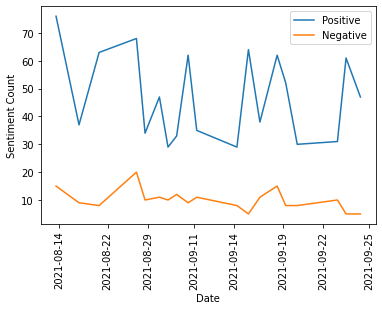

In [19]:
ax = sns.lineplot(x="Date", y="Positive", data = match_sentiments, label="Positive")
ax = sns.lineplot(x="Date", y="Negative", data = match_sentiments, label="Negative")
ax.set_xticklabels(labels=x_dates, rotation=90)
ax.set_ylabel("Sentiment Count")

In [20]:
import pandas as pd
def clean_data(data):
    #convert tweets to lower case
    data['Text'] = data['Text'].str.lower()
    stop = set(stopwords.words('english'))

    #url removes
    data['Text'] = data['Text'].str.replace(r'(https|http)?:\/(\w|\.|\/|\?|\=|\&|\%)*\b','')
    data['Text'] = data['Text'].str.replace(r'www\.\S+\.com','')

    #removes retweets & cc
    data['Text'] = data['Text'].str.replace(r'rt|cc', '')

    #hashtags removes
    data['Text'] = data['Text'].str.replace(r'#\S+', '')

    #user mention removes
    data['Text'] = data['Text'].str.replace(r'@\S+', '')

    #emoji 
    data['Text'] = data['Text'].str.replace(r'[^\x00-\x7F]+', '')

    #html tags
    data['Text'] = data['Text'].str.replace(r'<.*?>', '')

    #removes extra spaces
    data['Text'] = data['Text'].str.replace(r' +', ' ')

    #punctuation
    data['Text'] = data['Text'].str.replace('[{}]'.format(string.punctuation), '')

#     #stop words removes
#     data['Text'] = data['Text'].apply(lambda x: [item for item in x if item not in stop])

#     #convert preprocessed list words to string 
#     data['Text'] = data['Text'].apply(' '.join)
    return data


import spacy
import string
nlp = spacy.load("en_core_web_sm")
import nltk
from nltk.corpus import stopwords

def pos_tagging(data):
    req_tag = ['NN']
    extracted_words = []
    i = 0
    try:
        for ind, x in data.iterrows():
            doc = nlp(x["Text"])
            for token in doc:
                i += 1
                if token.tag_ in req_tag and token.shape_ != 'x' and token.shape_ != 'xx' and token.shape_ != 'xxx':
                    extracted_words.append(token.lemma_)
        return extracted_words
    except Exception as e:
        print("Exception", e)
        return extracted_words

extracted_words = []
for file in files:
    data = pd.read_csv(file)
    data = clean_data(data)
    extract_words = pos_tagging(data)
    extracted_words.append(extract_words)

extracted_words = [item for t in extracted_words for item in t]
from collections import Counter
word_freq = Counter(extracted_words)
print(word_freq.most_common(10))

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  if __name__ == '__main__':
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  if sys.path[0] == '':
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  from ipykernel import kernelapp as app
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_l

[('goal', 57), ('trafford', 54), ('time', 33), ('team', 31), ('boss', 30), ('game', 28), ('change', 27), ('today', 23), ('season', 22), ('night', 18)]


In [21]:
### Official -- 
# [('goal', 57), ('trafford', 54), ('time', 33), ('team', 31), ('boss', 30), ('game', 28), ('change', 27),
# ('today', 23), ('season', 22), ('night', 18)]


### Fan -- 
# [('game', 475), ('team', 340), ('time', 337), ('goal', 328), ('today', 318), ('manager', 273), 
# ('season', 258), ('club', 245), ('league', 238), ('ball', 219)]


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anishajauhari/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


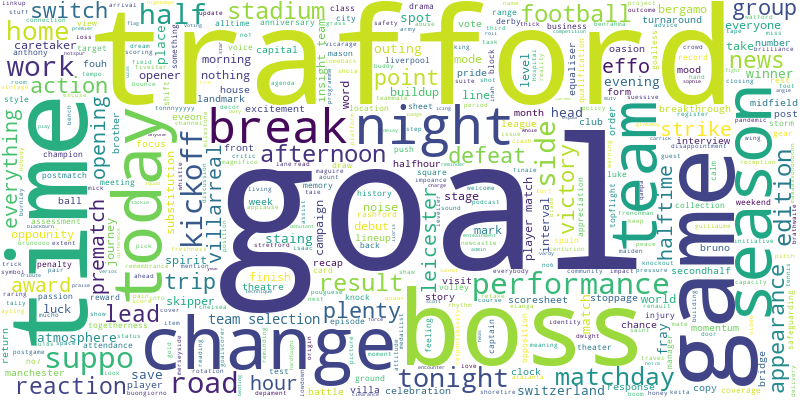

In [22]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(stopwords.words('portuguese'))
stop_words.extend(stopwords.words('french'))
stop_words.extend(stopwords.words('german'))

from wordcloud import WordCloud

long_string = ','.join(list(extracted_words))
wordcloud = WordCloud(width = 800, height = 400,background_color="white", max_words=1000, contour_width=5, contour_color='steelblue', stopwords = stop_words)
wordcloud.generate(long_string)
wordcloud.to_image()